In [ ]:
from platform import python_version

print(python_version())

3.10.14


In [ ]:
import numpy as np
import torch
import os
import json
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
import random
from skimage import transform
import warnings
import nibabel as nib
from tqdm import tqdm
from segment_anything import sam_model_registry
import torch.nn.functional as F
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
dataset_path="/home/manuri/data/Task01_BrainTumour_org/"

In [ ]:
json_path="/home/manuri/data/Task01_BrainTumour/"

In [ ]:
# Load the image files from the original source folder

json_filename = os.path.join(json_path, "dataset.json")

try:
    with open(json_filename, "r") as fp:
        experiment_data = json.load(fp)
except IOError as e:
    print("File {} doesn't exist. It should be part of the "
          "Decathlon directory".format(json_filename))

output_channels = experiment_data["labels"]
input_channels = experiment_data["modality"]
description = experiment_data["description"]
name = experiment_data["name"]
release = experiment_data["release"]
license = experiment_data["licence"]
reference = experiment_data["reference"]
tensorImageSize = experiment_data["tensorImageSize"]
numFiles = experiment_data["numTraining"]
numFiles_Test = experiment_data["numTest"]

filenames = {}
img = []
label = []
for idx in range(numFiles_Test):
    img.append(os.path.join(dataset_path,experiment_data["test"][idx]["image"]))
    label.append(os.path.join(dataset_path,experiment_data["test"][idx]["label"]))

filenames['images'] = img
filenames['label'] = label

In [ ]:
#filenames

In [ ]:
len(filenames['images'])

73

In [ ]:

def plot_prediction(mri,mask,prediction,slice_no,channel):
    slice_num = slice_no  # example slice number (choose between 0 and 154)
    channel = channel     # example channel (0: FLAIR, 1: T1, 2: T1-Gd, 3: T2)
    #cmap = colors.ListedColormap(['black', 'red','green','yellow','blue'])

    # Extract the corresponding slice and channel from the transformed image and mask
    slice_image = mri[:, :, slice_num, channel]
    slice_mask = mask[:, :, slice_num]

    pred_slice = prediction[:, :, slice_num]

    # Original image and mask
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    axes[0].imshow(slice_image,cmap='gray')
    axes[0].set_title('MRI Image')
    axes[0].axis('off')

    axes[1].imshow(slice_mask)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted mask
    axes[2].imshow(pred_slice)
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_classby_results(mri, mask, prediction,mod_no, slice_num=None):
    colors = ['#440154', '#3b528b', '#21918c', '#fde725', '#d62728']  # Black, Blue, Orange, Green, Red
    cmap = [LinearSegmentedColormap.from_list(f'custom_{i}', ['#440154', color], N=256) for i, color in enumerate(colors)]

    if slice_num is None:
        slice_num = mri.shape[2] // 2  # Middle slice by default

    # Determine the number of unique classes in the prediction
    num_classes = len(np.unique(prediction))

    # Create a figure with a row for each class plus two additional rows
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(f"MRI Segmentation Results - Slice {slice_num}", fontsize=16)

    # Plot true image slice (using the first channel of MRI)
    axes[0].imshow(mri[:, :, slice_num, mod_no], cmap='gray')
    axes[0].set_title("MRI Image Slice")
    axes[0].axis('off')

    # Plot ground truth mask
    axes[1].imshow(mask[:, :, slice_num], cmap='viridis')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    # Plot prediction mask for class 1 edema
    class_mask = (prediction[:, :, slice_num] == 1).astype(int)
    axes[2].imshow(class_mask, cmap=cmap[1])
    axes[2].set_title("Edema")
    axes[2].axis('off')

    # Plot prediction mask for class 2 non-enhancing
    class_mask = (prediction[:, :, slice_num] == 2).astype(int)
    axes[3].imshow(class_mask, cmap=cmap[2])
    axes[3].set_title("Non-enhancing")
    axes[3].axis('off')

    # Plot prediction mask for class 2 non-enhancing
    class_mask = (prediction[:, :, slice_num] == 3).astype(int)
    axes[4].imshow(class_mask, cmap=cmap[3])
    axes[4].set_title("Enhancing")
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Load, preprocess data and generate the segementation masks
def load_nifti(file_path):
    return nib.load(file_path).get_fdata()

def preprocess_slice(slice_data, target_size=(1024, 1024)):
    """
    Preprocess a single slice of MRI data.

    Args:
    slice_data (np.ndarray): Input 2D slice of MRI data
    target_size (tuple): Desired output size (height, width)

    Returns:
    np.ndarray: Preprocessed slice with shape (*target_size, 3)
    """
    # Ensure the input is 2D
    if slice_data.ndim != 2:
        raise ValueError(f"Expected 2D input, got shape {slice_data.shape}")

    # Handle NaN values
    if np.isnan(slice_data).any():
        #warnings.warn("NaN values found in input slice. Replacing with zeros.")
        slice_data = np.nan_to_num(slice_data, nan=0.0)

    # Clip extreme values (e.g., outliers)
    p1, p99 = np.percentile(slice_data, (1, 99))
    slice_data = np.clip(slice_data, p1, p99)

    # Normalize to [0, 1] range
    slice_min, slice_max = slice_data.min(), slice_data.max()
    if slice_min == slice_max:
        #warnings.warn("Constant intensity slice encountered. Returning zeros.")
        return np.zeros((*target_size, 3), dtype=np.float32)

    slice_data = (slice_data - slice_min) / (slice_max - slice_min)

    # Resize the slice
    if slice_data.shape != target_size:
        slice_data = transform.resize(
            slice_data,
            target_size,
            order=3,  # cubic spline interpolation
            mode='constant',
            anti_aliasing=True,
            preserve_range=True
        )

    # Ensure the output is in [0, 1] range after resize
    slice_data = np.clip(slice_data, 0, 1)

    # Convert to RGB-like format
    slice_data_rgb = np.stack([slice_data] * 3, axis=-1)

    return slice_data_rgb.astype(np.float32)

def evaluate_slice(model, image_slice, mask_slice, device):
    H, W = image_slice.shape
    image_slice = preprocess_slice(image_slice)  # Now uses the improved function
    image_tensor = torch.tensor(image_slice).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        image_embedding = model.image_encoder(image_tensor)

    box = get_bounding_box(mask_slice)
    box_1024 = np.array(box) / np.array([W, H, W, H]) * 1024
    box_1024 = box_1024[None, :]

    pred_mask = medsam_inference(model, image_embedding, box_1024, H, W)
    pred_mask = transform.resize(pred_mask, (H, W), order=0, preserve_range=True, anti_aliasing=False)

    return pred_mask.astype(np.uint8)

def get_bounding_box(mask):
    # Get bounding box for the tumor region (any non-background label)
    rows = np.any(mask > 0, axis=1)
    cols = np.any(mask > 0, axis=0)

    if np.sum(rows) == 0 or np.sum(cols) == 0:
        # If there's no tumor in this slice, return a small central box
        #print(mask.shape)
        h, w = mask.shape
        center_h, center_w = h // 2, w // 2
        box_size = 10  # Small box size
        return [center_w - box_size // 2, center_h - box_size // 2,
                center_w + box_size // 2, center_h + box_size // 2]

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Add a small padding to the bounding box
    padding = 10
    rmin = max(0, rmin - padding)
    rmax = min(mask.shape[0] - 1, rmax + padding)
    cmin = max(0, cmin - padding)
    cmax = min(mask.shape[1] - 1, cmax + padding)

    return [cmin, rmin, cmax, rmax]

def evaluate_volume(model, image_volume, mask_volume, device):
    predictions = []
    for i in range(image_volume.shape[2]):  # Iterate through slices
        image_slice = image_volume[:,:,i,0] if image_volume.ndim == 4 else image_volume[:,:,i]
        mask_slice = mask_volume[:,:,i]

        pred_slice = evaluate_slice(model, image_slice, mask_slice, device)
        predictions.append(pred_slice)

    return np.stack(predictions, axis=-1)

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 1:  # (4,)
        box_torch = box_torch.unsqueeze(0).unsqueeze(0)  # (1, 1, 4)
    elif len(box_torch.shape) == 2:  # (B, 4) or (1, 4)
        box_torch = box_torch.unsqueeze(1)  # (B, 1, 4) or (1, 1, 4)

    #print("box_torch shape:", box_torch.shape)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )
    medsam_seg = (low_res_pred > 0.5).squeeze().cpu().numpy().astype(np.uint8)

    if medsam_seg.ndim > 2:
        medsam_seg = medsam_seg[0]

    return medsam_seg

In [ ]:
# Load the pretrained model from the saved folder
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH).to(device)
model.eval()

/home/manuri/MyEnvs/Python310/lib/python3.10/site-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_lo

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


Prediction -1

In [ ]:
mask_volume = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_037.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
image_volume = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_037.nii.gz").get_fdata().astype(np.float32)

In [ ]:
pred_volume_37 = evaluate_volume(model, image_volume, mask_volume, device)

In [ ]:
pred_volume_37.shape

(128, 128, 160)

In [ ]:
image_volume.shape

(128, 128, 160, 4)

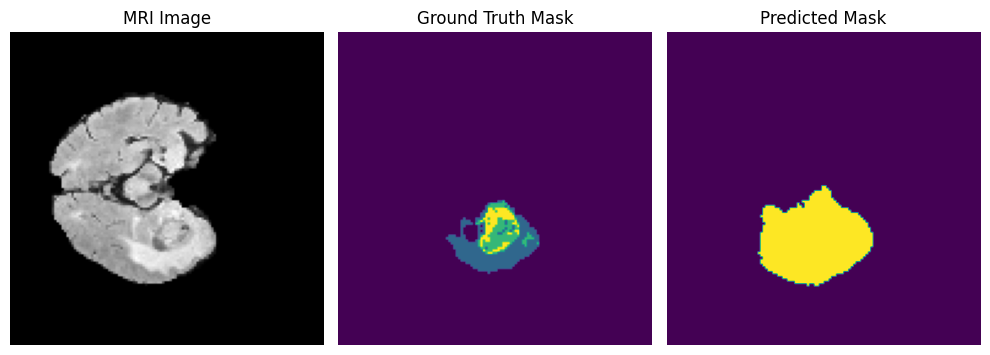

In [ ]:
plot_prediction(image_volume,mask_volume,pred_volume_37,50,0)

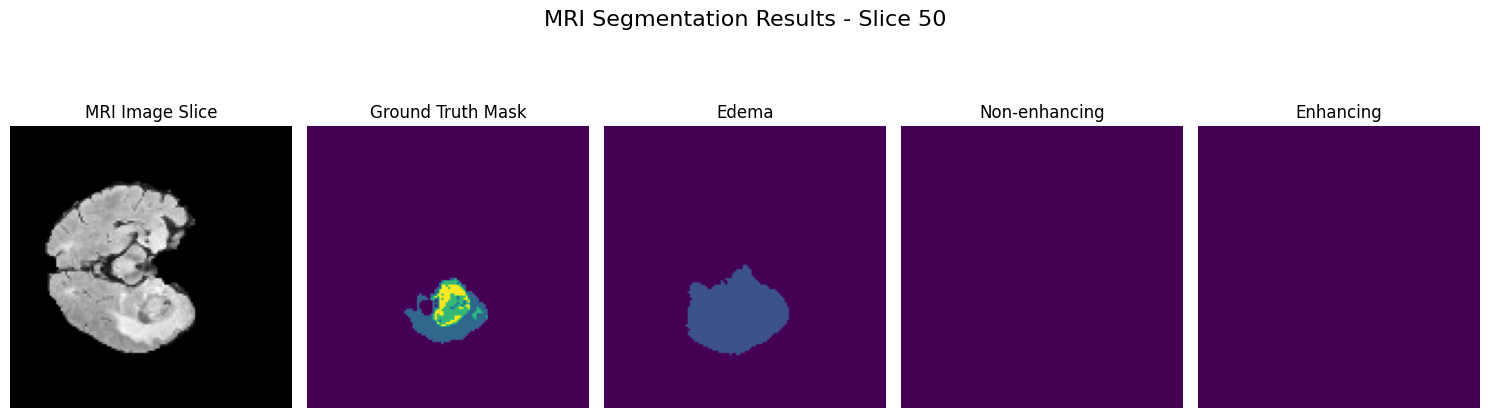

In [ ]:
plot_classby_results(image_volume,mask_volume,pred_volume_37,0,50)

Prediction -2

In [ ]:
mask_volume = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_469.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
image_volume = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_469.nii.gz").get_fdata().astype(np.float32)

In [ ]:
pred_volume_469 = evaluate_volume(model, image_volume, mask_volume, device)

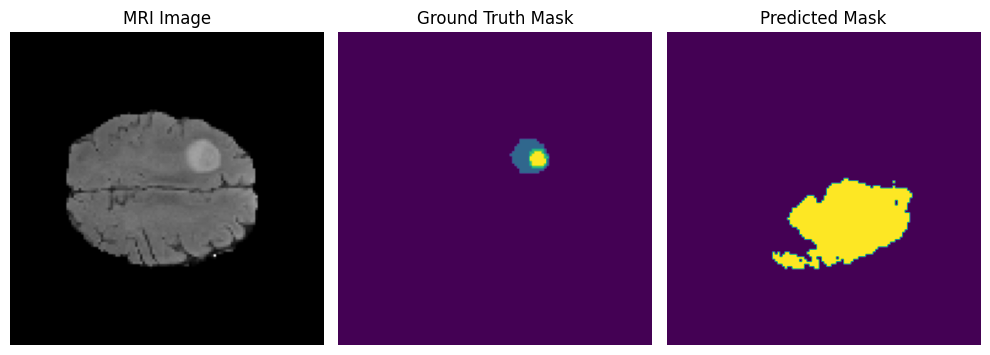

In [ ]:
plot_prediction(image_volume,mask_volume,pred_volume_469,100,0)

Prediction -3

In [ ]:
mask_volume = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_154.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
image_volume = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_154.nii.gz").get_fdata().astype(np.float32)

In [ ]:
pred_volume_154 = evaluate_volume(model, image_volume, mask_volume, device)

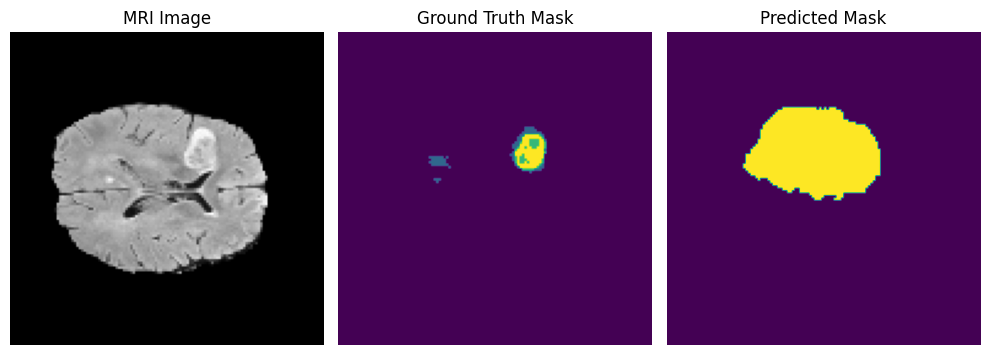

In [ ]:
plot_prediction(image_volume,mask_volume,pred_volume_154,80,0)

Prediction -4

In [ ]:
mask_volume = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_329.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
image_volume = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_329.nii.gz").get_fdata().astype(np.float32)

In [ ]:
pred_volume_329 = evaluate_volume(model, image_volume, mask_volume, device)

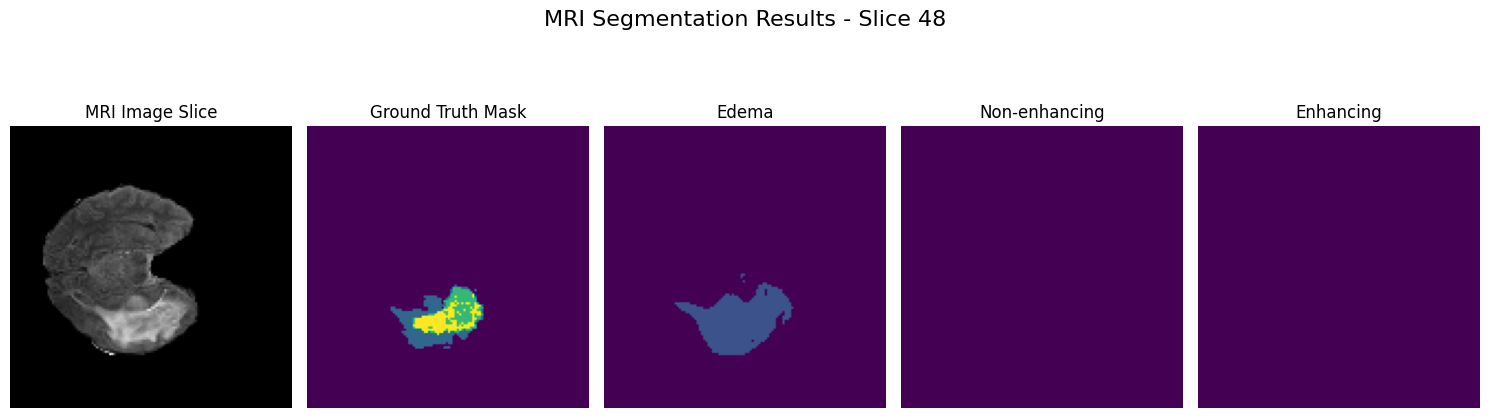

In [ ]:
plot_classby_results(image_volume,mask_volume,pred_volume_329,0,48)

Prediction -5

In [ ]:
mask_volume = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_351.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
image_volume = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_351.nii.gz").get_fdata().astype(np.float32)

In [ ]:
pred_volume_351 = evaluate_volume(model, image_volume, mask_volume, device)

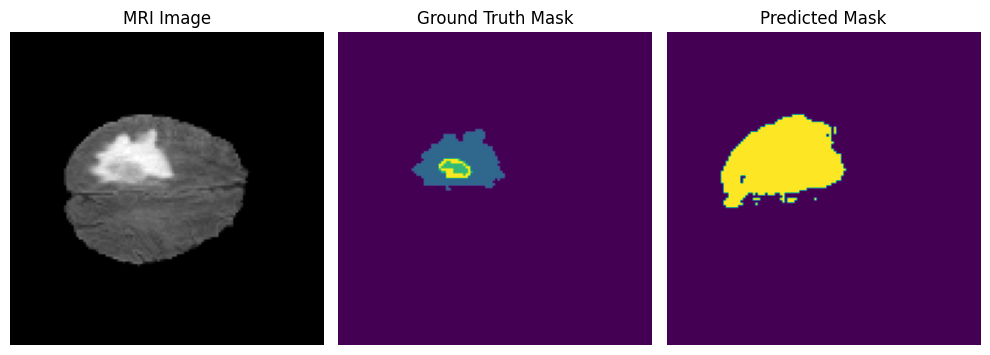

In [ ]:
plot_prediction(image_volume,mask_volume,pred_volume_351,98,0)

Prediction -6

In [ ]:
mask_volume = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_207.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
image_volume = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_207.nii.gz").get_fdata().astype(np.float32)

In [ ]:
pred_volume_207 = evaluate_volume(model, image_volume, mask_volume, device)

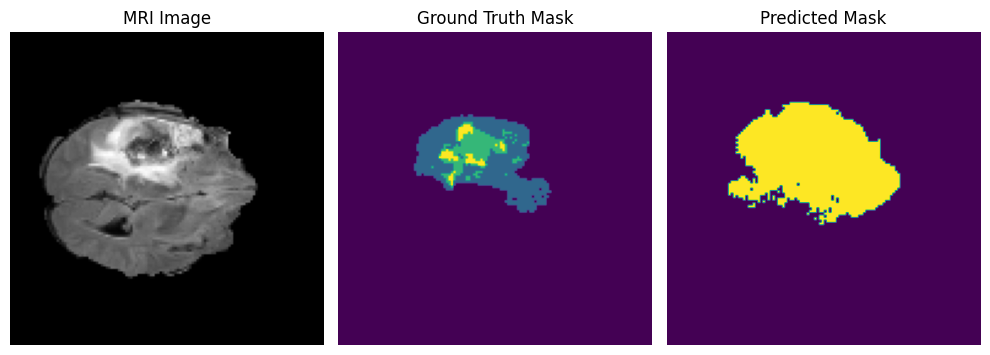

In [ ]:
plot_prediction(image_volume,mask_volume,pred_volume_207,65,0)

Prediction -7

In [ ]:
mask_volume = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_474.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
image_volume = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_474.nii.gz").get_fdata().astype(np.float32)

In [ ]:
pred_volume_474 = evaluate_volume(model, image_volume, mask_volume, device)

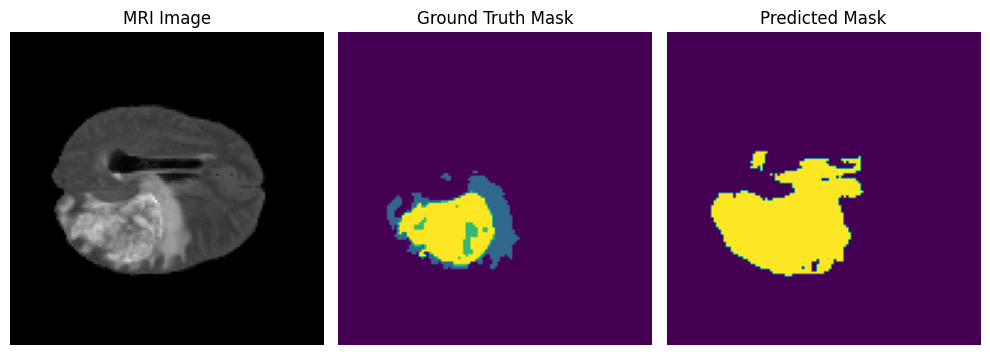

In [ ]:
plot_prediction(image_volume,mask_volume,pred_volume_474,90,0)